In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
from sklearn.cross_validation import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
import imhandle as imh
#from extract_data import *
from dual_IDG import DualImageDataGenerator

In [54]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, \
    Lambda, UpSampling2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
#from keras.metrics import fmeasure
from keras_logger import CSVLogger, ComprehensiveLogger

In [55]:
K.set_image_dim_ordering('th')

In [4]:
def mean_IOU_cpu_for_binary(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    intersection, union = np.logical_and(X, Y).sum(axis=(1, 2, 3)), np.logical_or(X, Y).sum(axis=(1, 2, 3))
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = np.where(union == 0, 1, union)
    return np.mean(intersection / union.astype(np.float64))


def mean_IOU_cpu(X, Y):
    X_fl = X > 0.5
    Y_fl = Y > 0.5
    
    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), 1, union)
    return K.mean(intersection / K.cast(union, 'float32'))

In [5]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.greater(X_fl, 0.5)
    Y_fl = K.greater(Y_fl, 0.5)
    
    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), 1, union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_for_flattened(x, y):
    x = K.clip(x, K.epsilon(), 1.)
    y = K.clip(y, K.epsilon(), 1.)
    x = K.greater(x, 0.5)
    y = K.greater(y, 0.5)
    
    intersection = K.sum(x * y, axis=1)
    union = K.sum(K.maximum(x, y), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), 1, union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [6]:
def bce_gpu(y_true, y_pred):
    # Credits: https://www.kaggle.com/c/ultrasound-nerve-segmentation/forums/t/22951/would-like-to-see-how-others-approached-this-problem-doesn-t-have-to-be/131719
    
    # Workaround for shape bug.
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    
    bce = K.mean(K.binary_crossentropy(y_true_f, y_pred_f), axis=-1)
    return K.mean(bce)

In [170]:
def dice(y_true, y_pred):
    """This provides a continious approximation to Dice scor.
    It equals Dice score when both y_true and y_pred are binary tensors, 
    however, it also supports tensors with values in [0, 1].
    Therefore, -dice() and -log_dice() can be used for training."""
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def f_score(y_true, y_pred):
    # This function returns f-score (harmonic mean between precision and recall).
    # It is based on Keras function, but first casts inputs to float type.
    
    return fmeasure(K.cast(y_true, 'float32'), K.cast(y_pred, 'float32'))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.greater(y_true, 0.5)
    y_pred_f = K.greater(y_pred, 0.5)
    return dice(y_true_f, y_pred_f)

In [165]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

In [9]:
#h5f = h5py.File("../data/hdf5_datasets/all_data.hdf5", "r")
h5f = h5py.File("../data/hdf5_datasets/DRISHTI_GS.hdf5", "r")

In [10]:
#h5f.close()

### U-Net architecture

<img src="../reports/pics/u-net-architecture.png" width=60%>

In [166]:
def get_unet(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    return model

In [167]:
def get_unet_light_and_heavy(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    return model

In [171]:
model = get_unet_light_and_heavy(img_rows=512, img_cols=512)
model.compile(#optimizer=Adam(lr=1e-6), 
              optimizer=SGD(lr=3e-4, momentum=0.98),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

In [172]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 3, 512, 512)   0                                            
____________________________________________________________________________________________________
convolution2d_179 (Convolution2D)(None, 32, 512, 512)  896         input_10[0][0]                   
____________________________________________________________________________________________________
dropout_94 (Dropout)             (None, 32, 512, 512)  0           convolution2d_179[0][0]          
____________________________________________________________________________________________________
convolution2d_180 (Convolution2D)(None, 32, 512, 512)  9248        dropout_94[0][0]                 
___________________________________________________________________________________________

#### Training on DRISHTI-GS

In [60]:
# Loading full images of desired resolution:
X = h5f['DRISHTI-GS/512 px/images']
Y = h5f['DRISHTI-GS/512 px/cup']

In [61]:
X, Y

(<HDF5 dataset "images": shape (50, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (50, 512, 512, 1), type "|u1">)

In [89]:
n_folds = 5
train_idx_cv, test_idx_cv = [], []

for _train_idx, _test_idx in KFold(X.shape[0], n_folds):
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)

In [95]:
len(X), len(train_idx_cv[0]), len(test_idx_cv[0])

(50, 40, 10)

In [125]:
#train_idx = h5f['DRISHTI-GS/train_idx']
#test_idx = h5f['DRISHTI-GS/test_idx']

train_idx = train_idx_cv[0]
test_idx = test_idx_cv[0]

In [126]:
len(X), len(train_idx), len(test_idx)

(50, 40, 10)

#### Generator for training and data augmentation

In [103]:
train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=50, width_shift_range=0.15, height_shift_range=0.15,
                                   zoom_range=(0.5, 1.0),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()
#augm_idg = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True,
#                              horizontal_flip=True, vertical_flip=True,
#                              rotation_range=0.1, width_shift_range=0.1, height_shift_range=0.1,
#                              zoom_range=(1.0, 2.0),
#                              fill_mode='constant', cval=0.0)
# if using featurewise_center, featurewise_std_normalization or zca_whitening,
# augm_idg.fit(X_train, Y_train) is needed first

In [104]:
X_train = np.array([X[i] for i in train_idx])
X_train = tf_to_th_encoding(X_train)
#mean_test_img = np.mean([X[i] for i in test_idx], axis=0) / 255.0    # should not be used probably
mean_color = np.mean(X_train, axis=(0, 2, 3), keepdims=True)
std_color = np.std(X_train, axis=(0, 2, 3), keepdims=True)

del X_train

In [127]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    # the following line thresholds segmentation mask for DRISHTI-GS, since it contains averaged soft maps:
    batch_y = batch_y >= 128
    # if line above is uncommented, division by 255.0 is not needed
    #batch_y = batch_y / 255.0
    
    if train_or_test == 'train':
        batch_X, batch_y = train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    elif train_or_test == 'test':
        batch_X, batch_y = test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    #batch_X -= mean_train_img
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i]) 
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, train_or_test='train', batch_size=3, return_orig=False, stationary=False):
    """Gets random batch of data, 
    divides by 255,
    feeds it to DualImageDataGenerator."""
    
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i] for i in idx]
        batch_X = np.array(batch_X).copy()
        batch_y = [y[i] for i in idx]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

In [128]:
gen = data_generator(X, Y, 'train', batch_size=1)
batch = gen.__next__()
batch[0].shape

/home/ubuntu/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


(1, 3, 512, 512)

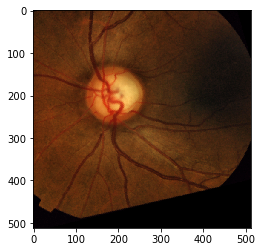

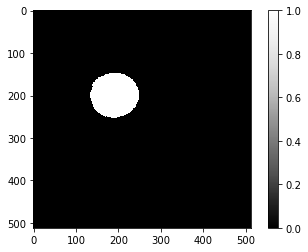

In [129]:
fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
#plt.colorbar(mappable=fig)
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.colorbar(); plt.show()

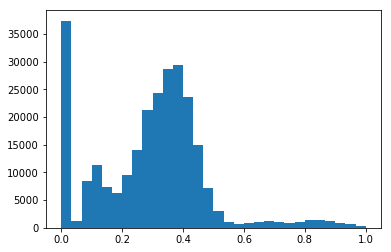

In [130]:
_ = plt.hist(batch[0][0][0].ravel(), bins=30)

In [179]:
arch_name = "OD Cup, U-Net on DRISHTI-GS fold 0 512 px, binary output maps and binary Dice metric, SGD, high augm with more zoom, CLAHE, log_dice loss"
weights_folder = '../models_weights/' \
                 '{},{}/'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name)

In [180]:
weights_folder

'../models_weights/24.02,04:10,OD Cup, U-Net on DRISHTI-GS fold 0 512 px, binary output maps and binary Dice metric, SGD, high augm with more zoom, CLAHE, log_dice loss/'

In [176]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

/home/ubuntu/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


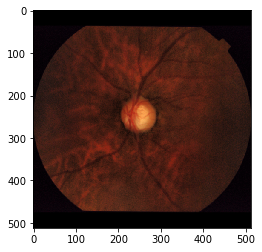

(10, 3, 512, 512) (10, 1, 512, 512)


In [177]:
X_valid, Y_valid = data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True).__next__()
plt.imshow(np.rollaxis(X_valid[0], 0, 3)); plt.show()
print(X_valid.shape, Y_valid.shape)

In [ ]:
history = model.fit_generator(data_generator(X, Y, train_or_test='train', batch_size=1), 
                              samples_per_epoch=len(train_idx),
                              max_q_size=1,
                              
                              validation_data=(X_valid, Y_valid),
                              #validation_data=data_generator(X, Y, train_or_test='test', batch_size=1),
                              #nb_val_samples=100,
                              
                              nb_epoch=500, verbose=1,
                              
                              callbacks=[CSVLogger(folder(weights_folder) + '/' + 'training_log.csv', append=True),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=30),
                                         ModelCheckpoint(folder(weights_folder) + '/' + \
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5',
                                               monitor='val_dice_metric', mode='max', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

Epoch 1/500


/home/ubuntu/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


40/40 [==============================] - 21s - loss: 0.4118 - mean_IOU_gpu: 0.4988 - dice_metric: 0.6417 - val_loss: 0.9247 - val_mean_IOU_gpu: 0.2450 - val_dice_metric: 0.3789

In [ ]:
print model.optimizer.lr.get_value()

In [ ]:
model.optimizer.lr.set_value(3e-4)
model.optimizer.momentum.set_value(0.98)

In [ ]:
img_no = 30

batch_X = tf_to_th_encoding(X[img_no:img_no + 1].copy())
batch_y = tf_to_th_encoding(Y[img_no:img_no + 1].copy())
#batch_X, batch_y = test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
batch_X, batch_y = preprocess(batch_X, batch_y, 'test')
pred = model.predict(batch_X)[0, 0] > 0.5
corr = Y[img_no][..., 0]
print 'predicted:'
plt.imshow(pred, cmap=plt.cm.Greys_r)
plt.show()
print 'correct:'
plt.imshow(corr, cmap=plt.cm.Greys_r)
plt.show()
print 'original image:'
plt.imshow(X[img_no], cmap=plt.cm.Greys_r)
plt.show()

In [ ]:
mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval()

In [ ]:
plt.hist(pred.ravel())

### Comprehensive visual check

In [ ]:
# Function for rescaling cropped cup region and putting it back into original image,
# and resizing the result to 256 x 256.

'''    # not needed for working with images of original size
def rescale_back(cropped, rectangle, orig_size=(512, 512), resulting_size=(256, 256)):
    # cropped must be a grayscale image 
    # rectangle must be an iterable (min_i, min_j, max_i, max_j)
    
    min_i, min_j, max_i, max_j = rectangle
    part_rescaled = sp.misc.imresize(cropped, (max_i - min_i + 1, max_j - min_j + 1))
    resulting_img = np.zeros(orig_size, dtype=cropped.dtype)
    resulting_img[min_i:max_i + 1, min_j:max_j + 1] = part_rescaled
    resulting_img = sp.misc.imresize(resulting_img, resulting_size)
    return resulting_img
'''

In [153]:
optic_disc = h5f['DRISHTI-GS/512 px/disc']

image #0


/home/ubuntu/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


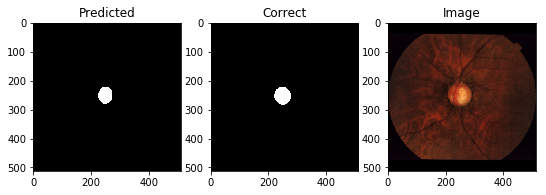

IOU: 0.7945157885551453
Dice: 0.8854932301740812
image #1


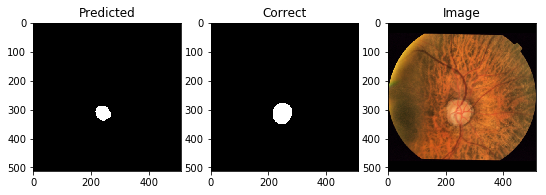

IOU: 0.5321031212806702
Dice: 0.6946048506847055
image #2


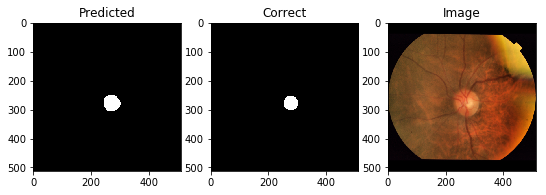

IOU: 0.7626034617424011
Dice: 0.8653148345784418
image #3


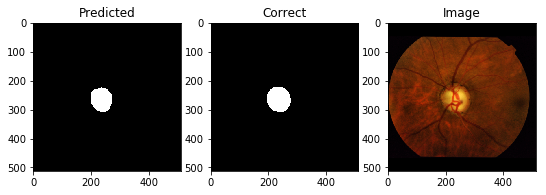

IOU: 0.8599554896354675
Dice: 0.9247054491899853
image #4


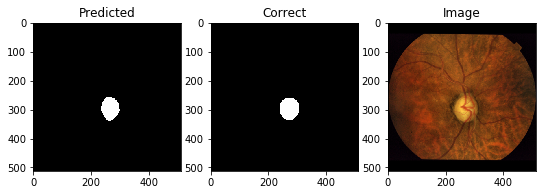

IOU: 0.8352782726287842
Dice: 0.9102470041574957
image #5


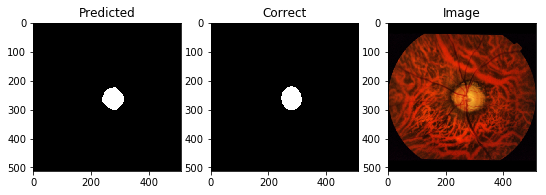

IOU: 0.8918350338935852
Dice: 0.942825361512792
image #6


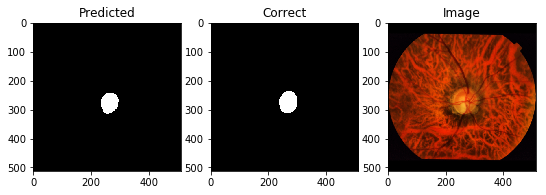

IOU: 0.8480697274208069
Dice: 0.9177897574123989
image #7


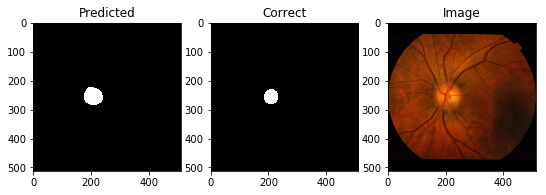

IOU: 0.6364749073982239
Dice: 0.7778608825729244
image #8


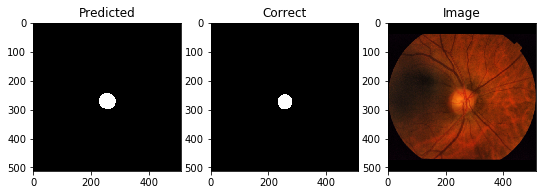

IOU: 0.7907787561416626
Dice: 0.8831674599740372
image #9


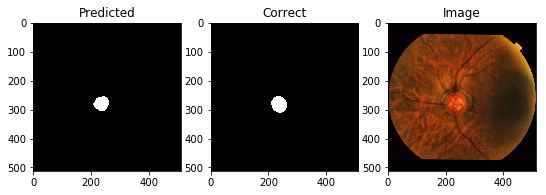

IOU: 0.7946916222572327
Dice: 0.8856024358416703


In [158]:
pred_iou, pred_dice = [], []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = tf_to_th_encoding(X[img_no:img_no + 1].copy())
    batch_y = tf_to_th_encoding(Y[img_no:img_no + 1].copy())
    #batch_X = batch_X / 255.0
    #batch_y = batch_y / 255.0
    #batch_X, batch_y = test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    batch_X, batch_y = preprocess(batch_X, batch_y, 'test')
    
    pred = model.predict(batch_X)[0, 0] > 0.5
    #pred = model.predict(X_valid[i:i + 1])[0, 0] > 0.5
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    # intersecting prediction with an optic disc map
    pred = np.where(optic_disc[img_no, ..., 0], pred, 0.0)
    
    # for cropped version - comparing with original image
    #pred = rescale_back(pred, disc_locations[img_no])
    #corr = Y_orig[img_no, ..., 0]
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    #cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval()
    #cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval()
    cur_iou = mean_IOU_gpu(pred[None, None, ...], Y_valid[i:i + 1]).eval()
    cur_dice = dice(pred[None, None, ...], Y_valid[i:i + 1]).eval()
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(float(cur_iou))
    pred_dice.append(float(cur_dice))

In [159]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.774630618095
0.86876112661


In [148]:
dice(Y_valid > 0.5, model.predict(X_valid) > 0.5).eval()

array(0.8542623519897461, dtype=float32)

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  3.,  0.,  3.,  2.]),
 array([ 0.        ,  0.08243938,  0.16487876,  0.24731814,  0.32975752,
         0.4121969 ,  0.49463629,  0.57707567,  0.65951505,  0.74195443,
         0.82439381]),
 <a list of 10 Patch objects>)

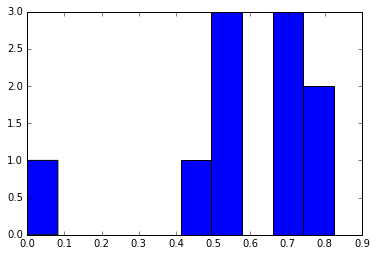

In [70]:
plt.hist(loss)

### Loading model

In [143]:
load_model = False   # lock
if not load_model:
    print('load_model == False')
else:
    # specify file:
    #model_path = '../models_weights/01.11,22:38,U-Net on DRIONS-DB 256 px, Adam, augm, log_dice loss/' \
    #    'weights.ep-20-val_mean_IOU-0.81_val_loss_0.08.hdf5'
    
    # or get the most recent file in a folder:
    #model_folder = '../models_weights/23.02,14:52,OD Cup, U-Net on DRISHTI-GS fold 0 512 px, binary output maps, SGD, high augm with more zoom, CLAHE, log_dice loss/'
    
    model_folder = weights_folder
    
    model_path = max(glob.glob(os.path.join(model_folder, '*.hdf5')), key=os.path.getctime)
    if load_model and not os.path.exists(model_path):
        raise Exception('`model_path` does not exist')
    print('Loading weights from', model_path)

    if load_model:
        #with open(model_path + ' arch.json') as arch_file:
        #    json_string = arch_file.read()
        #new_model = model_from_json(json_string)
        model.load_weights(model_path)
    
    # Reading log statistics
    import pandas as pd
    
    log_path = os.path.join(weights_folder, 'training_log.csv')
    if os.path.exists(log_path):
        log = pd.read_csv(log_path)
        print('\nmax val mean IOU: {}, at row:'.format(log['val_mean_IOU_gpu'].max()))
        print(log.loc[log['val_mean_IOU_gpu'].argmax()])
        if 'val_dice' in log.columns:
            print('\n' + 'max val dice: {}, at row:'.format(log['val_dice'].max()))
            print(log.loc[log['val_dice'].argmax()])

Loading weights from ../models_weights/23.02,14:52,OD Cup, U-Net on DRISHTI-GS fold 0 512 px, binary output maps, SGD, high augm with more zoom, CLAHE, log_dice loss/last_checkpoint.hdf5


### Save model

In [ ]:
model.save('../models_weights/weights-ep-13_val_mean_IOU-0.061_val_loss_1.82.hdf5')

In [ ]:
model.save_weights('../models_weights/weights-ep-13_val_mean_IOU-0.061_val_loss_1.82_weights_only.hdf5')